## Classificador binário para características morfométricas de núcleo/citoplasma de células cervicais 

In [ ]:
!pip install pyefd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/shape_based_CRIC_Hclassifier")

In [ ]:
import numpy as np
import pandas as pd 
from math import sqrt
import os
import sys
import csv
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow 
from skimage import morphology, measure
from skimage.draw import polygon, polygon_perimeter
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis

import pyefd
from pyefd import elliptic_fourier_descriptors, normalize_efd

from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import feature_selection as fs

from datetime import datetime

# pay attention to capitalization below!
from spFSR import SpFSR
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE

from itertools import cycle
from random import randint
from random import sample

import xgboost as xgb 


In [ ]:
Bethesda_classes = {'Normal':0, 'ASC-US':1, 'ASC-H':2, 'LSIL':3,'HSIL':4, 'Invasive Carcinoma':5} 
Bethesda_idx_classes = {0: 'Normal', 1:'ASC-US', 2:'ASC-H', 3:'LSIL',4: 'HSIL', 5:'Invasive Carcinoma'} 

### Funções para normalizar (todos os dados)

In [ ]:
## Normaliza dados
def normalize(min, max, value):
    return (value-min)/(max - min)

def normalize_prop(prop, df):
    min = np.min(df[prop].values)
    max = np.max(df[prop].values)
    return (normalize(min, max, df[prop].values))

# Filtra/normaliza dados
def normalize_dataset(df, n_efd_coeffs):
  dataset = df.copy()
   
  dataset.areaN = normalize_prop('areaN', df)
  dataset.eccenN = normalize_prop('eccenN', df) 
  dataset.extentN = normalize_prop('extentN', df)
  dataset.periN = normalize_prop('periN', df)
  dataset.maxAxN = normalize_prop('maxAxN', df)  
  dataset.minAxN = normalize_prop('minAxN', df)  
  dataset.compacN = normalize_prop('compacN', df)
  dataset.circuN = normalize_prop('circuN', df)
  dataset.convexN = normalize_prop('convexN', df)
  dataset.hAreaN = normalize_prop('hAreaN', df)
  dataset.solidN = normalize_prop('solidN', df) 
  dataset.equidiaN = normalize_prop('equidiaN', df) 
  dataset.elonN = normalize_prop('elonN', df)
  dataset.eN = normalize_prop('eN', df)  
  dataset.kN = normalize_prop('kN', df)  
  dataset.mrdN = normalize_prop('mrdN', df)  
  dataset.ardN = normalize_prop('ardN', df)  
  dataset.fdN = normalize_prop('fdN', df)       
  efds = ['efdN'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df) 
    
  dataset.areaC = normalize_prop('areaC', df)
  dataset.eccenC = normalize_prop('eccenC', df) 
  dataset.extentC = normalize_prop('extentC', df)
  dataset.periC = normalize_prop('periC', df)
  dataset.maxAxC = normalize_prop('maxAxC', df)  
  dataset.minAxC = normalize_prop('minAxC', df)
  dataset.compacC = normalize_prop('compacC', df)
  dataset.circuC = normalize_prop('circuC', df)
  dataset.convexC = normalize_prop('convexC', df)
  dataset.hAreaC = normalize_prop('hAreaC', df)
  dataset.solidC = normalize_prop('solidC', df) 
  dataset.equidiaC = normalize_prop('equidiaC', df) 
  dataset.elonC = normalize_prop('elonC', df)
  dataset.eC = normalize_prop('eC', df)  
  dataset.kC = normalize_prop('kC', df)  
  dataset.mrdC = normalize_prop('mrdC', df)  
  dataset.ardC = normalize_prop('ardC', df)  
  dataset.fdC = normalize_prop('fdC', df)       
  efds = ['efdC'+str(i) for i in range(1,(n_efd_coeffs*4 + 1 - 3))]
  for efd in efds: 
      dataset[efd] = normalize_prop(efd, df)   

  #dataset.nucleus_position = normalize_prop('nucleus_position', df)
 
  return dataset

 ###  Funções - organiza dados (x, y, ids) e filtra base para diferentes classificadores:

In [ ]:
 #Monta base e retorna 3 dataframes: data (x), target(2,3 e 6 classes), image/cell_id
def get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       features_to_fit):
 
    data =  pd.DataFrame(data=np.vstack([
                          data_normal.values,
                          data_ascus.values,
                          data_asch.values,
                          data_lsil.values, 
                          data_hsil.values,
                          data_car.values]), 
                         columns = data_car.columns)
    
    ## ID's imagens e celulas
    image_cells_ids= data[['image_id', 'cell_id']].copy() 
    
    ##Ajusta y(target) para classificação binária, ternária além de bethesda
    y = np.array(data['bethesda'].values)
    y_bin = np.array(y)
    y_ter = np.array(y)
        
    for i in range(data.shape[0]):
         y_bin[i] = 0 if y_bin[i]==0 else 1
    
    for i in range(data.shape[0]):
          if y_ter[i] == 3:  ##Lsil
             y_ter[i] = 1
          elif (y_ter[i] == 4 or y_ter[i] == 5):  ##HSIl e Car
                y_ter[i] = 2
                
    target = pd.DataFrame(data = np.stack([y_bin,
                                           y_ter,
                                           y], axis=-1),
                          columns = ['binary', 'ternary', 'bethesda'])
    
    data = data[features_to_fit]      
    return data, target, image_cells_ids

In [ ]:
## Prepara dados para tuning de parâmetros
## Valores para type: 1 (normal/anormal), 2(baixo/alto grau), 3(ASCUS/LSIL), 4(ASCH/HSIL/CAR)
def filter_dataXY(X, y, cls_type):
    if cls_type == 1: # (normal/anormal)
        return (X, y['binary'])
    elif cls_type == 2: # (baixo/alto grau)
          lines = filter_lines(y['ternary'], [1,2])
          return (X.loc[lines], y['ternary'].loc[lines])  
    elif cls_type == 3: # (ASCUS/LSIL)
          lines = filter_lines(y['bethesda'], [1,3])
          return (X.loc[lines], y['bethesda'].loc[lines])  
    else: #(ASCH/HSIL/Car)    
          lines = filter_lines(y['bethesda'], [2,4,5])
          return (X.loc[lines], y['bethesda'].loc[lines])                           

## Filtra linhas
def filter_lines(y, cls):
   lines = []
   if len(cls) == 2:
     filter1 = (y == cls[0]) 
     filter2 = (y == cls[1])
     for i, (idx1, idx2) in enumerate(zip(filter1.index, filter2.index)):
        if (filter1[idx1] or filter2[idx2]):
            lines.append(idx1)
   else: 
     filter1 = (y == cls[0]) 
     filter2 = (y == cls[1])
     filter3 = (y == cls[2])
     for i, (idx1, idx2, idx3) in enumerate(zip(filter1.index, filter2.index, filter3.index)):
        if (filter1[idx1] or filter2[idx2] or filter3[idx3]):
            lines.append(idx1)
   return lines

## Contabiliza tempo:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

### Funções para seleção de características:

In [ ]:
def list_all_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
   
   aux=['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 
   for name_f in aux:
       feature_labels.append(name_f)

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']

   for name_f in aux:
       feature_labels.append(name_f)
   return feature_labels   

def list_all_EFD_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C

   feature_labels = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]      
   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
   return feature_labels   


def list_all_nucleus_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels=['areaN', 'eccenN', 'extentN', 'periN', 'maxAxN', 'minAxN',
                   'compacN', 'circuN', 'convexN', 'hAreaN', 'solidN', 'equidiaN', 
                   'elonN', 'sdnrlN', 'raN', 'riN', 'eN', 'kN', 'mrdN', 'ardN', 'fdN'] 
   
   efdNs = ['efdN'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdNs:
       feature_labels.append(name_f) 
    
   #TODO: incluir features abaixo? 
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)

   return feature_labels   

def list_all_cyto_features(n_efd_coeffs):
   # n_efd_coeffs: número de coefficientes a considerar (série Eliptica de fourier - EFD) para N e C
     
   feature_labels =['areaC', 'eccenC', 'extentC', 'periC', 'maxAxC', 'minAxC',
         'compacC', 'circuC', 'convexC', 'hAreaC', 'solidC', 'equidiaC', 
          'elonC', 'sdnrlC', 'raC', 'riC', 'eC', 'kC', 'mrdC', 'ardC', 'fdC'] 

   efdCs = ['efdC'+str(i) for i in range(1, (n_efd_coeffs*4+1 - 3))]  
   for name_f in efdCs:
       feature_labels.append(name_f)
    
   #aux = ['ratio_NC', 'ratio_NC_per', 'ratio_NC_hArea', 'nucleus_position']
   #for name_f in aux:
   #    feature_labels.append(name_f)
    
   return feature_labels   

In [ ]:
len(list_all_features(20)), len(list_all_nucleus_features(20)), len(list_all_cyto_features(20)), len(list_all_EFD_features(20))

(200, 98, 98, 154)

In [ ]:
### FEATURES SELECTION: "Simultaneous Perturbation Stochastic Approximation (SPSA) for feature selection and ranking" 
# Fonte: An implementation of feature selection and ranking via SPSA based on the article "K-best feature selection and ranking via stochastic approximation"(https://www.sciencedirect.com/science/article/abs/pii/S0957417422018826) 
# Código: https://github.com/akmand/spFSR.git
def features_selection_spfsr(X_train, y_train, N_features = None):        
    #Atenção: X_train contem apenas colunas de features!
    
    # pred_type needs to be 'c' for classification and 'r' for regression datasets
    sp_engine = SpFSR(x=X_train.values, y=y_train.values, pred_type='c', wrapper=None, scoring='accuracy')
    
    np.random.seed(999)

    if N_features is not None:
        sp_output = sp_engine.run(num_features= N_features, print_freq = 9000000).results    
    else:
        sp_output = sp_engine.run(num_features=0, print_freq = 9000000).results    

    fs_indices_spfsr = sp_output.get('selected_features')
    best_features_spfsr = X_train.columns[fs_indices_spfsr].values
    feature_importances_spfsr = sp_output.get('selected_ft_importance')
    return(best_features_spfsr, feature_importances_spfsr)

                             
### FEATURES SELECTION: método Mutual Information
def features_selection_mi(X_train, y_train, N_features = 20):    
    
    ## Feature Selection using Mutual Info  
    fs_fit_mutual_info = fs.SelectKBest(fs.mutual_info_classif, k=N_features)
    fs_fit_mutual_info.fit_transform(X_train, y_train)

    # ordena extrai do maior score para o menor entre as n_features mais importantes
    fs_indices_mutual_info = np.argsort(fs_fit_mutual_info.scores_)[::-1][0:N_features] # extrai do maior score para o menor entre as 10 features mais importantes
    best_features_mutual_info = X_train.columns[fs_indices_mutual_info].values  
    feature_importances_mutual_info = fs_fit_mutual_info.scores_[fs_indices_mutual_info]

    best_features_MI = np.asarray(best_features_mutual_info)
    feature_importances_MI = np.asarray(feature_importances_mutual_info, dtype = np.float32)    
    return (best_features_MI, feature_importances_MI)


## Plota gráfico de ganho para features selecionadas: 
def plot_imp(best_features_1, scores_1, method_name_1,
            best_features_2, scores_2, method_name_2):   
    
    plt.style.use("bmh")
    #plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))
    axs[0].tick_params(labelsize= 'small')
    axs[0].barh(best_features_1, scores_1, color= 'blue', height=0.75)    
    axs[0].set(xlim=[min(0, (np.min(scores_1))), max(0.8, np.max(scores_1)+0.1)], xlabel='Score', ylabel='Feature', title= method_name_1 + ' Scores')
    axs[1].tick_params(labelsize= 'small')
    axs[1].set(xlim=[min(0, np.min(scores_2)), max(0.8, np.max(scores_2)+0.1)], xlabel='Score', ylabel='Feature', title=method_name_2 + ' Scores')
    axs[1].barh(best_features_2, scores_2, color= 'green')    
    
    #fig.suptitle('Feature Selection') 
    fig.subplots_adjust(left=0.1, right=0.9, wspace=0.3)
    plt.show()
 


In [ ]:
# contabiliza estatísticas (feature scores):
def acum_feature_importances(best_features, best_features_score, acum_dict):    
    for feature, score in zip(best_features, best_features_score):
        acum_dict[feature] = (acum_dict[feature] + score)
    return acum_dict

# Conjunto final de features e scores em ordem decrescente de importância
def resume_feature_importance(acum_dict, N_iter, N_features = None):
    acum_dict_tuples = sorted(acum_dict.items(), key=lambda item:item[1], reverse=True)
    best_features = []
    feature_importances = []
    for i in list(range(len(acum_dict_tuples))):
        if acum_dict_tuples[i][1] == 0:
                break
        if N_features is not None:
            if i == N_features:
                break
        best_features.append(acum_dict_tuples[i][0])
        feature_importances.append(acum_dict_tuples[i][1]/N_iter)

    best_features = np.asarray(best_features)
    feature_importances = np.asarray(feature_importances, dtype = np.float32)    
    return (best_features, feature_importances)

### Lê arquivo (features):

In [ ]:
N_EFD_COEFFS = 20

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/shape_based_CRIC_Hclassifier/dataCRIC.csv', sep='|', header=0)
df = normalize_dataset(df, n_efd_coeffs= N_EFD_COEFFS)
 

In [ ]:
df

,image_id,cell_id,areaN,eccenN,extentN,periN,maxAxN,minAxN,compacN,circuN,...,efdC73,efdC74,efdC75,efdC76,efdC77,ratio_NC,ratio_NC_per,ratio_NC_hArea,nucleus_position,bethesda
0,1.0,14796.0,0.007403,0.606414,0.842276,0.031326,0.036711,0.083827,0.024126,0.863522,...,0.156532,0.321490,0.859931,0.382225,0.302311,0.017236,0.115646,0.016730,0.099098,0.0
1,1.0,14797.0,0.009371,0.541484,0.808102,0.035945,0.039493,0.095649,0.018763,0.891071,...,0.150931,0.317850,0.859539,0.369221,0.299938,0.010656,0.089517,0.010168,0.121456,0.0
2,1.0,14798.0,0.007275,0.313794,0.884418,0.029457,0.025365,0.097062,0.018895,0.890378,...,0.153458,0.315454,0.861978,0.367980,0.302076,0.007400,0.073961,0.006897,0.043773,0.0
3,1.0,14799.0,0.010570,0.489270,0.778201,0.040199,0.040900,0.103428,0.021001,0.879403,...,0.157254,0.319562,0.860312,0.382943,0.303682,0.028309,0.154784,0.027752,0.128927,0.0
4,1.0,14801.0,0.009115,0.296366,0.842276,0.036826,0.031283,0.106376,0.024456,0.861871,...,0.147193,0.314554,0.860292,0.359672,0.300094,0.021569,0.129992,0.020738,0.069245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,399.0,11539.0,0.028927,0.838629,0.579720,0.094256,0.134656,0.118369,0.041270,0.784196,...,0.152113,0.318217,0.859606,0.370535,0.299400,0.206211,0.149094,0.085315,1.943974,5.0
3229,399.0,11540.0,0.025333,0.874227,0.645532,0.094611,0.135676,0.100778,0.064959,0.692461,...,0.150010,0.322108,0.859366,0.375599,0.300755,0.245537,0.247086,0.136756,0.916374,5.0
3230,400.0,11535.0,0.017031,0.910741,0.390863,0.092280,0.136377,0.078990,0.131860,0.507358,...,0.153944,0.319972,0.860379,0.372458,0.303245,0.191508,0.471092,0.188343,0.326252,5.0
3231,400.0,11536.0,0.020797,0.949322,0.528816,0.105709,0.169029,0.065965,0.137720,0.494794,...,0.151898,0.320620,0.859608,0.370771,0.299599,0.111823,0.078186,0.023058,3.177247,5.0


In [ ]:
# Separa dados por classe de maneira balanceada:
data_normal = df[df['bethesda'] == 0].copy()
data_normal.set_index((i for i in range(data_normal.shape[0])), inplace=True)

data_ascus = df[df['bethesda'] == 1].copy()
data_ascus.set_index((i for i in range(data_ascus.shape[0])), inplace=True)

data_asch = df[df['bethesda'] == 2].copy()
data_asch.set_index((i for i in range(data_asch.shape[0])), inplace=True)

data_lsil = df[df['bethesda'] == 3].copy()
data_lsil.set_index((i for i in range(data_lsil.shape[0])), inplace=True)

data_hsil = df[df['bethesda'] == 4].copy()
data_hsil.set_index((i for i in range(data_hsil.shape[0])), inplace=True)

data_car = df[df['bethesda'] == 5].copy()
data_car.set_index((i for i in range(data_car.shape[0])), inplace=True)

print("--- Totais por classe --- ")               
print("Normal...: ", data_normal.values.shape[0])               
print("ASC-Us...: ", data_ascus.values.shape[0])               
print("ASC-H....: ", data_asch.values.shape[0])               
print("LSIL.....: ", data_lsil.values.shape[0])               
print("HSIL.....: ", data_hsil.values.shape[0])               
print("Carcinoma: ", data_car.values.shape[0]) 
 

--- Totais por classe --- 
Normal...:  862
ASC-Us...:  286
ASC-H....:  536
LSIL.....:  598
HSIL.....:  874
Carcinoma:  77


#### Gera dataframes: dados (data), classes (target) e Ids (image/cell)

In [ ]:
# Monta base (data, target, image/cells ids)
data, target, image_cells_ids= get_database_data_targe_ids(data_normal, data_ascus, 
                       data_lsil, data_asch, data_hsil,data_car,
                       list_all_features(N_EFD_COEFFS))
 

## Features selection - experiment nº1:  (nucleus + cytoplasm)

In [ ]:
features_desc = "Selected features to nucleus and cytoplasm"
N_FEATURES = 30
N_ITER = 10

## Dicts feature importances (stats):
features = list_all_features(N_EFD_COEFFS) 
aux = [0.0 for i in features]
features_importance_dict_spfsr_1 = dict(zip(features, aux))
features_importance_dict_spfsr_2 = dict(zip(features, aux))
features_importance_dict_spfsr_3 = dict(zip(features, aux))
features_importance_dict_spfsr_4 = dict(zip(features, aux))

features_importance_dict_mi_1 = dict(zip(features, aux))
features_importance_dict_mi_2 = dict(zip(features, aux))
features_importance_dict_mi_3 = dict(zip(features, aux))
features_importance_dict_mi_4 = dict(zip(features, aux))
start_time = timer()


In [ ]:
# Loop principal:

for it in range(N_ITER):
    print('Iteração número: ', it)

    # Separa dados para treino/validação e teste:
    (X_train, X_test, y_train, y_test, image_cells_ids_train, image_cells_ids_test) = train_test_split(data, target, image_cells_ids, test_size=0.2)

    X_train = X_train[features]

    #### Seleção de características:  classificadores (1, 2, 3, 4)
    best_features_MI_1, feature_importances_MI_1 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=1), N_features= N_FEATURES)
    best_features_spfsr_1, feature_importances_spfsr_1 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=1), N_features= N_FEATURES)
    best_features_MI_2, feature_importances_MI_2 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=2), N_features= N_FEATURES)
    best_features_spfsr_2, feature_importances_spfsr_2 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=2), N_features= N_FEATURES)
    best_features_MI_3, feature_importances_MI_3 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=3), N_features= N_FEATURES)
    best_features_spfsr_3, feature_importances_spfsr_3 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=3), N_features= N_FEATURES)
    best_features_MI_4, feature_importances_MI_4 = features_selection_mi(*filter_dataXY(X_train, y_train, cls_type=4), N_features = N_FEATURES)
    best_features_spfsr_4, feature_importances_spfsr_4 = features_selection_spfsr(*filter_dataXY(X_train, y_train, cls_type=4), N_features= N_FEATURES)

    ### Acumula seleções:   
    features_importance_dict_spfsr_1 = acum_feature_importances(best_features_spfsr_1, feature_importances_spfsr_1, features_importance_dict_spfsr_1)    
    features_importance_dict_spfsr_2 = acum_feature_importances(best_features_spfsr_2, feature_importances_spfsr_2, features_importance_dict_spfsr_2)    
    features_importance_dict_spfsr_3 = acum_feature_importances(best_features_spfsr_3, feature_importances_spfsr_3, features_importance_dict_spfsr_3)    
    features_importance_dict_spfsr_4 = acum_feature_importances(best_features_spfsr_4, feature_importances_spfsr_4, features_importance_dict_spfsr_4)    
    features_importance_dict_mi_1 = acum_feature_importances(best_features_MI_1, feature_importances_MI_1, features_importance_dict_mi_1)    
    features_importance_dict_mi_2 = acum_feature_importances(best_features_MI_2, feature_importances_MI_2, features_importance_dict_mi_2)    
    features_importance_dict_mi_3 = acum_feature_importances(best_features_MI_3, feature_importances_MI_3, features_importance_dict_mi_3)    
    features_importance_dict_mi_4 = acum_feature_importances(best_features_MI_4, feature_importances_MI_4, features_importance_dict_mi_4)    


timer(start_time)
## Finaliza seleções:
selected_features_spfsr_1, selected_features_scores_spfsr_1 = resume_feature_importance(features_importance_dict_spfsr_1, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_2, selected_features_scores_spfsr_2 = resume_feature_importance(features_importance_dict_spfsr_2, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_3, selected_features_scores_spfsr_3 = resume_feature_importance(features_importance_dict_spfsr_3, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_spfsr_4, selected_features_scores_spfsr_4 = resume_feature_importance(features_importance_dict_spfsr_4, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_1, selected_features_scores_mi_1 = resume_feature_importance(features_importance_dict_mi_1, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_2, selected_features_scores_mi_2 = resume_feature_importance(features_importance_dict_mi_2, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_3, selected_features_scores_mi_3 = resume_feature_importance(features_importance_dict_mi_3, N_iter=N_ITER, N_features= N_FEATURES)
selected_features_mi_4, selected_features_scores_mi_4 = resume_feature_importance(features_importance_dict_mi_4, N_iter=N_ITER, N_features= N_FEATURES)

## Imprime features selecionadas:
print("1.MI\n",selected_features_mi_1, selected_features_scores_mi_1)
print("2.MI\n",selected_features_mi_2, selected_features_scores_mi_2)
print("3.MI\n",selected_features_mi_3, selected_features_scores_mi_3)
print("4.MI\n",selected_features_mi_4, selected_features_scores_mi_4)

print("1.SPFSR\n",selected_features_spfsr_1, selected_features_scores_spfsr_1)
print("2.SPFSR\n",selected_features_spfsr_2, selected_features_scores_spfsr_2)
print("3.SPFSR\n",selected_features_spfsr_3, selected_features_scores_spfsr_3)
print("4.SPFSR\n",selected_features_spfsr_4, selected_features_scores_spfsr_4)


Iteração número:  0


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  1


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  2


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  3


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  4


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  5


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  6


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  7


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  8


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu

Iteração número:  9


SpFSR-INFO: Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
INFO:SpFSR:Wrapper: RandomForestClassifier(class_weight='balanced_subsample', n_estimators=5,
                       random_state=1)
SpFSR-INFO: Hot start: True
INFO:SpFSR:Hot start: True
SpFSR-INFO: Hot start range: 0.2
INFO:SpFSR:Hot start range: 0.2
SpFSR-INFO: Feature weighting: False
INFO:SpFSR:Feature weighting: False
SpFSR-INFO: Scoring metric: accuracy
INFO:SpFSR:Scoring metric: accuracy
SpFSR-INFO: Number of jobs: 1
INFO:SpFSR:Number of jobs: 1
SpFSR-INFO: Number of observations in the dataset: 2586
INFO:SpFSR:Number of observations in the dataset: 2586
SpFSR-INFO: Number of observations used: 2500
INFO:SpFSR:Number of observations used: 2500
SpFSR-INFO: Number of features available: 200
INFO:SpFSR:Number of features available: 200
SpFSR-INFO: Number of features to select: 30
INFO:SpFSR:Number of features to select: 30
SpFSR-INFO: iter_no: 0, nu


 Time taken: 1 hours 49 minutes and 54.36 seconds.
1.MI
 ['ratio_NC' 'ratio_NC_per' 'ratio_NC_hArea' 'mrdN' 'eN' 'maxAxN' 'periN'
 'ardN' 'hAreaN' 'equidiaN' 'areaN' 'fdN' 'compacC' 'circuC' 'riN' 'areaC'
 'periC' 'hAreaC' 'minAxC' 'maxAxC' 'ardC' 'fdC' 'mrdC' 'equidiaC' 'eC'
 'circuN' 'compacN' 'riC' 'minAxN' 'convexN'] [0.3999775  0.39943117 0.39399529 0.3255511  0.3214567  0.3076071
 0.28875485 0.28440684 0.25138018 0.23973356 0.23884502 0.23291819
 0.22590384 0.2257921  0.22056462 0.21043624 0.1895116  0.18645631
 0.18379503 0.18354808 0.18101534 0.1809064  0.17947055 0.17752212
 0.1760346  0.17580989 0.17576486 0.17456889 0.14998305 0.07375818]
2.MI
 ['areaC' 'equidiaC' 'fdC' 'hAreaC' 'ardC' 'periC' 'ratio_NC_hArea'
 'ratio_NC' 'mrdC' 'maxAxC' 'eC' 'ratio_NC_per' 'riC' 'minAxC' 'circuC'
 'compacC' 'equidiaN' 'areaN' 'fdN' 'hAreaN' 'riN' 'periN' 'minAxN'
 'nucleus_position' 'ardN' 'solidC' 'maxAxN' 'extentC' 'mrdN' 'eN'] [0.5836767  0.5646905  0.561354   0.55579984 0.5533493  0.55

In [ ]:
print("1.MI\n",len(selected_features_mi_1), len(selected_features_scores_mi_1))
print("2.MI\n",len(selected_features_mi_2), len(selected_features_scores_mi_2))
print("3.MI\n",len(selected_features_mi_3), len(selected_features_scores_mi_3))
print("4.MI\n",len(selected_features_mi_4), len(selected_features_scores_mi_4))

print("1.SPFSR\n",len(selected_features_spfsr_1), len(selected_features_scores_spfsr_1))
print("2.SPFSR\n",len(selected_features_spfsr_2), len(selected_features_scores_spfsr_2))
print("3.SPFSR\n",len(selected_features_spfsr_3), len(selected_features_scores_spfsr_3))
print("4.SPFSR\n",len(selected_features_spfsr_4), len(selected_features_scores_spfsr_4))



1.MI
 30 30
2.MI
 30 30
3.MI
 30 30
4.MI
 30 30
1.SPFSR
 5 5
2.SPFSR
 10 10
3.SPFSR
 30 30
4.SPFSR
 10 10


In [ ]:
## Imprime features selecionadas:
print("1.MI\n",selected_features_mi_1, selected_features_scores_mi_1)
print("2.MI\n",selected_features_mi_2, selected_features_scores_mi_2)
print("3.MI\n",selected_features_mi_3, selected_features_scores_mi_3)
print("4.MI\n",selected_features_mi_4, selected_features_scores_mi_4)

print("1.SPFSR\n",selected_features_spfsr_1, selected_features_scores_spfsr_1)
print("2.SPFSR\n",selected_features_spfsr_2, selected_features_scores_spfsr_2)
print("3.SPFSR\n",selected_features_spfsr_3, selected_features_scores_spfsr_3)
print("4.SPFSR\n",selected_features_spfsr_4, selected_features_scores_spfsr_4)

1.MI
 ['ratio_NC' 'ratio_NC_per' 'ratio_NC_hArea' 'mrdN' 'eN' 'maxAxN' 'periN'
 'ardN' 'hAreaN' 'equidiaN' 'areaN' 'fdN' 'compacC' 'circuC' 'riN' 'areaC'
 'periC' 'hAreaC' 'minAxC' 'maxAxC' 'ardC' 'fdC' 'mrdC' 'equidiaC' 'eC'
 'circuN' 'compacN' 'riC' 'minAxN' 'convexN'] [0.3999775  0.39943117 0.39399529 0.3255511  0.3214567  0.3076071
 0.28875485 0.28440684 0.25138018 0.23973356 0.23884502 0.23291819
 0.22590384 0.2257921  0.22056462 0.21043624 0.1895116  0.18645631
 0.18379503 0.18354808 0.18101534 0.1809064  0.17947055 0.17752212
 0.1760346  0.17580989 0.17576486 0.17456889 0.14998305 0.07375818]
2.MI
 ['areaC' 'equidiaC' 'fdC' 'hAreaC' 'ardC' 'periC' 'ratio_NC_hArea'
 'ratio_NC' 'mrdC' 'maxAxC' 'eC' 'ratio_NC_per' 'riC' 'minAxC' 'circuC'
 'compacC' 'equidiaN' 'areaN' 'fdN' 'hAreaN' 'riN' 'periN' 'minAxN'
 'nucleus_position' 'ardN' 'solidC' 'maxAxN' 'extentC' 'mrdN' 'eN'] [0.5836767  0.5646905  0.561354   0.55579984 0.5533493  0.55057836
 0.54512364 0.53895366 0.5370372  0.5365704  

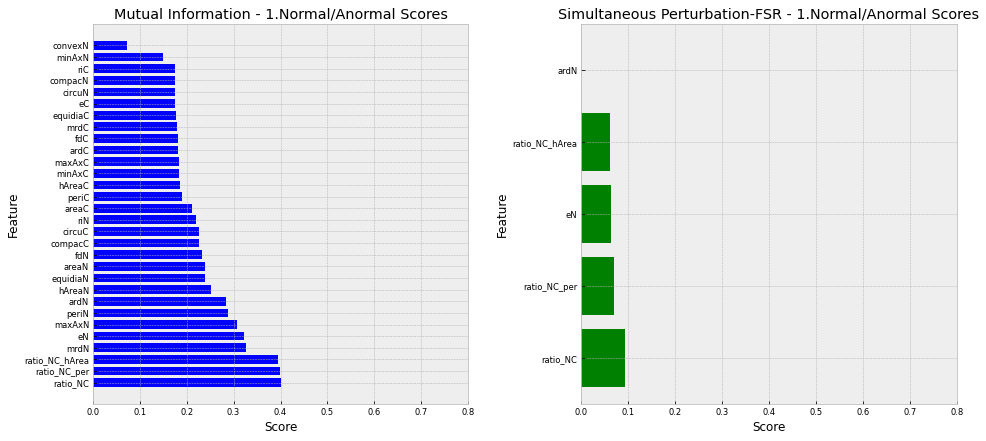

In [ ]:
plot_imp(selected_features_mi_1, selected_features_scores_mi_1, 'Mutual Information - 1.Normal/Anormal', 
         selected_features_spfsr_1, selected_features_scores_spfsr_1, 'Simultaneous Perturbation-FSR - 1.Normal/Anormal') # 

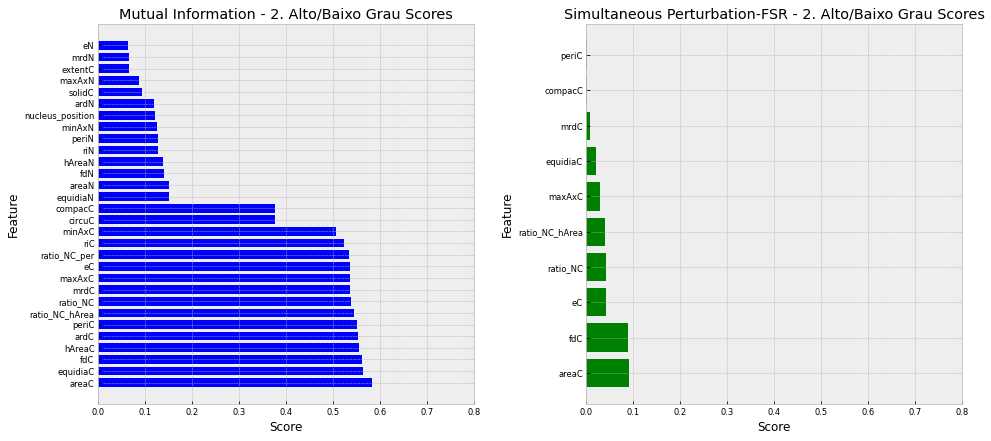

In [ ]:
plot_imp(selected_features_mi_2, selected_features_scores_mi_2, 'Mutual Information - 2. Alto/Baixo Grau', 
         selected_features_spfsr_2, selected_features_scores_spfsr_2, 'Simultaneous Perturbation-FSR - 2. Alto/Baixo Grau') # 

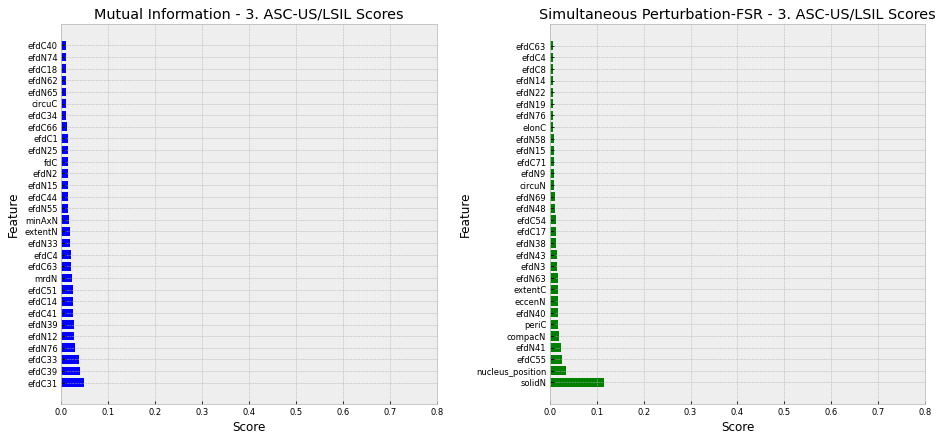

In [ ]:
plot_imp(selected_features_mi_3, selected_features_scores_mi_3, 'Mutual Information - 3. ASC-US/LSIL', 
         selected_features_spfsr_3, selected_features_scores_spfsr_3, 'Simultaneous Perturbation-FSR - 3. ASC-US/LSIL') # 

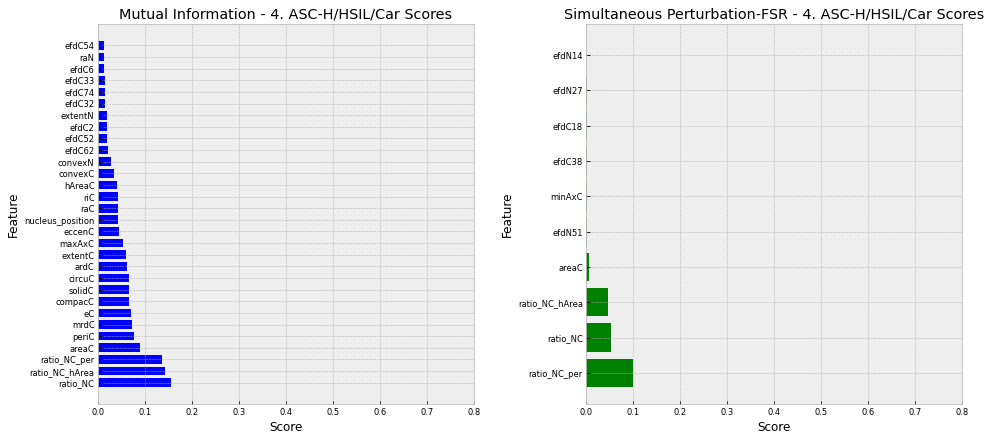

In [ ]:
plot_imp(selected_features_mi_4, selected_features_scores_mi_4, 'Mutual Information - 4. ASC-H/HSIL/Car', 
         selected_features_spfsr_4, selected_features_scores_spfsr_4, 'Simultaneous Perturbation-FSR - 4. ASC-H/HSIL/Car') # 